# Generate Predictions

### Predict, and save outputs and confidences to text

In [ ]:
# IMPORTANT: when changing filepath of dataset for "source" it is important to leave /**/**/* at the end, so it looks at all images (the filepath before that should point to the root folder of the processed images)
from ultralytics import YOLO
model = YOLO('./Training/2024-3-19/TUNING/tune/weights/best.pt')
source = './Datasets/Combined/_Processed11/**/**/*'
for r in model.predict(source='./Datasets/Combined/_Processed11/**/**/*', save_txt=True, save_conf=True, project="./Training/2024-3-19", stream=True):
    pass

### Organize the output text files into a CSV

In [14]:
# Organize those values
import os
import csv

def process_text_file(file_path):
    data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            columns = line.strip().split()
            label = columns[1].strip()
            value = columns[0].strip()
            data[label] = value
    return data

def main():
    folder_path = './Training/2024-3-19/predict/labels/'  # Replace with the actual path to your text files
    output_csv = './Training/2024-3-19/predict/outputAll.csv'

    file_names = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

    #header = ['Label'] + ['0-0.99', '1-4', '5-9', '10-24', '25-55']
    header = ['Label'] + ['00-0.49', '00.5-0.99', '01-2.49', '02.5-4.99', '05-9.99', '10-14.99', '15-20.99', '21-28.99', '29-36.99', '37-44.99', '45-55']

    with open(output_csv, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(header)

        for file_name in file_names:
            row_data = [file_name[:-4]]
            file_path = os.path.join(folder_path, file_name)
            file_data = process_text_file(file_path)

            for label in header[1:]:
                row_data.append(file_data.get(label, ''))

            csvwriter.writerow(row_data)

    print(f'CSV file "{output_csv}" has been created.')

if __name__ == "__main__":
    main()


CSV file "./Training/2024-3-19/predict/outputAll.csv" has been created.


### Fill missing entries with 0

In [ ]:
# Only top 5 confidence values are given, but there are 11 classes, so replace all the missing entries with 0
import pandas as pd

# Read the CSV file
df = pd.read_csv('./Training/2024-3-19/predict/outputAll.csv')

# Replace empty entries with 0
df.fillna(0, inplace=True)

# Save the modified data back to a CSV file
df.to_csv('./Training/2024-3-19/predict/outputAll.csv', index=False)


### Read recorded FNU values for each image from Master Dataset CSV file, and add them to a new "Truth" column in our predictions spreadsheet

In [16]:
# Add Truth
import pandas as pd

# Read the first CSV file
input_df = pd.read_csv('./Training/2024-3-19/predict/outputAll.csv')

# Read the second CSV file and select only the 'Image Name' and 'FNU' columns
lookup_df = pd.read_csv('./Training/2024-3-19/predict/_Master-Combined.csv', usecols=['Image Name', 'FNU'])

# Remove '.JPG' from labels in the second file
lookup_df['Image Name'] = lookup_df['Image Name'].str.replace('.JPG', '')
# Remove '.PNG' from labels in the second file
lookup_df['Image Name'] = lookup_df['Image Name'].str.replace('.png', '')

# Merge the two dataframes based on the 'Label' and 'Image Name' columns
merged_df = pd.merge(input_df, lookup_df, how='left', left_on='Label', right_on='Image Name')

# Drop the extra 'Image Name' column
merged_df = merged_df.drop(columns=['Image Name'])

# Rename the 'FNU' column to 'Truth'
merged_df = merged_df.rename(columns={'FNU': 'Truth'})

# Save the updated input file
merged_df.to_csv('./Training/2024-3-19/predict/output2All.csv', index=False)


-----
# Fit Linear Regression to the Predictions


RMSE:2.0551167134473727

Linear Regression Equation: 
y = 61.34 * <0-0.5> + 61.57 * <0.5-1> + 62.48 * <1-2.5> + 65.53 * <2.5-5> + 67.76 * <5-10> + 73.91 * <10-15> + 77.63 * <15-21> + 85.64 * <21-29> + 93.29 * <29-37> + 99.40 * <37-45> + 114.32 * <45-55> + -60.90

                            WLS Regression Results                            
Dep. Variable:                  Truth   R-squared:                       0.975
Model:                            WLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2349.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:54:52   Log-Likelihood:                -1416.2
No. Observations:                 662   AIC:                             2856.
Df Residuals:                     650   BIC:                             2910.
Df Model:                          11                                         
Covariance Type:        

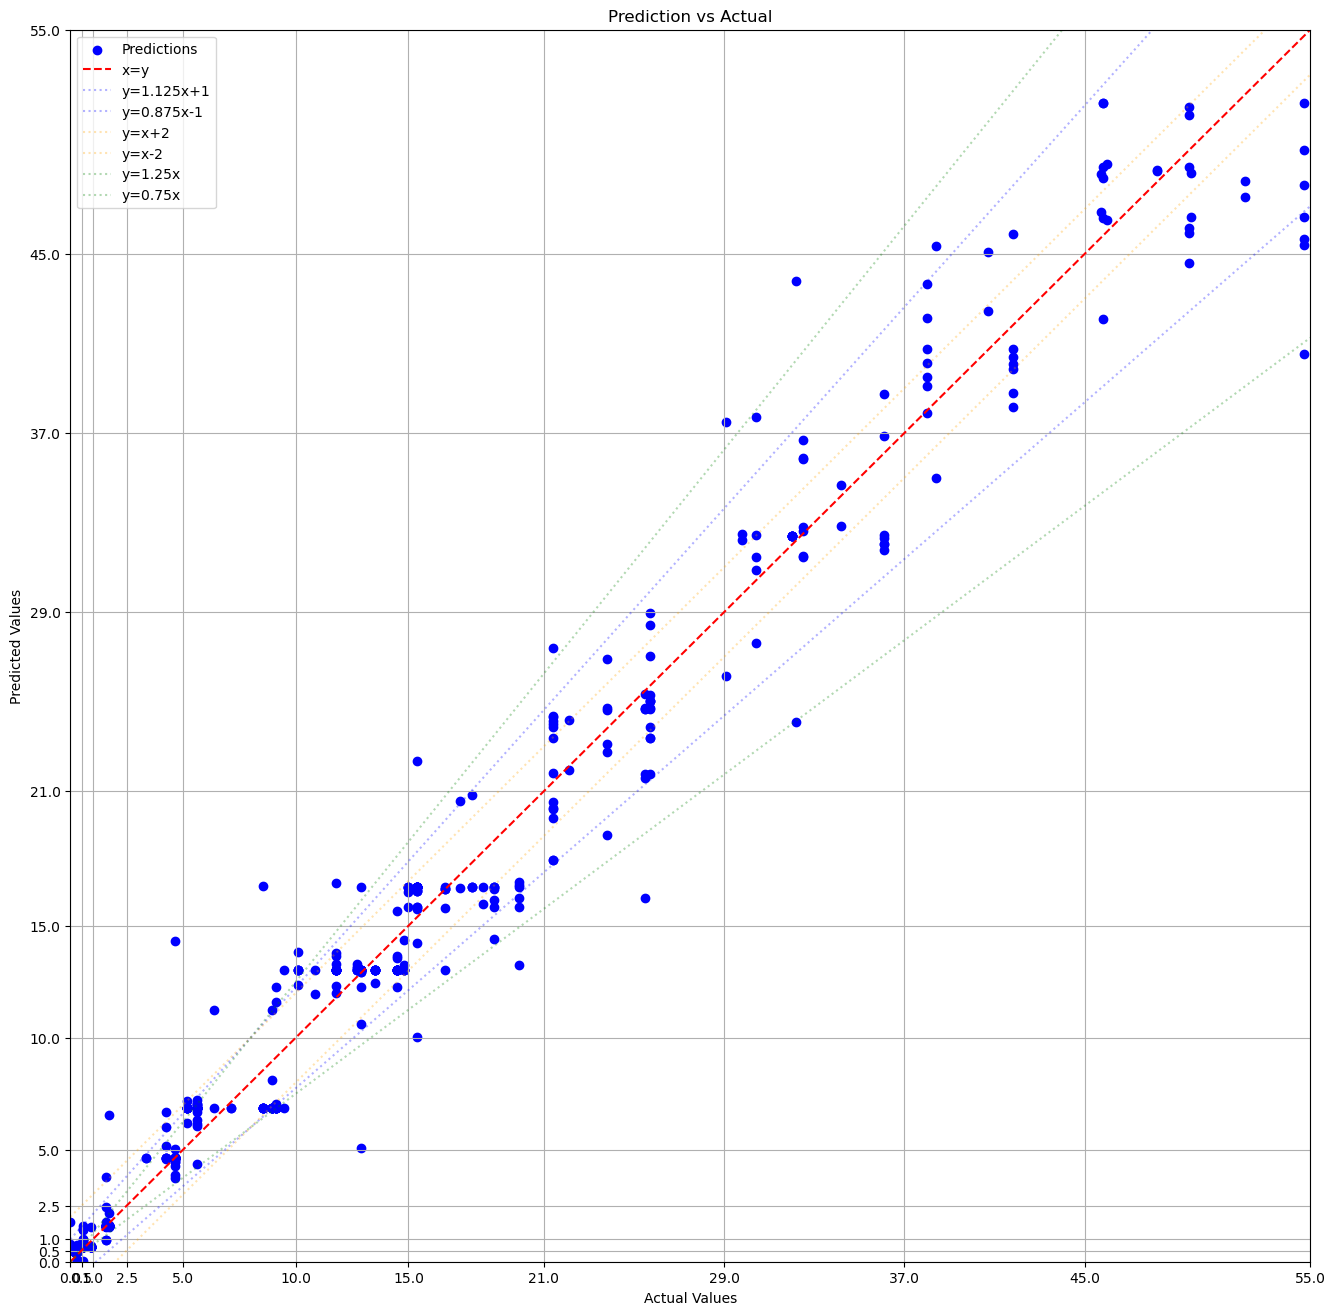

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

# Load the CSV file
csv_path = "./Training/2024-3-19/predict/output2All.csv"
data = pd.read_csv(csv_path)

# Extracting input variables (columns 2-12) and target variable (column 7)
X = data.iloc[:, 1:12]
y = data["Truth"]

X_pred = sm.add_constant(X)

model = sm.WLS(y, X_pred)
res = model.fit()
ypred = res.predict(X_pred)

rmse = rmse(y, ypred)
print(f'\nRMSE:{rmse}')


#-------- Printing Equation -----------
coefficients = res.params[1:]
intercept = res.params[0]

ranges = ["<0-0.5>", "<0.5-1>", "<1-2.5>", "<2.5-5>", "<5-10>", "<10-15>", "<15-21>", "<21-29>", "<29-37>", "<37-45>", "<45-55>"]

# Generate the equation string
equation = "y = "
for i, coef in enumerate(coefficients[:]): 
    equation += f"{coef:.2f} * {ranges[i]} + "
equation += f"{intercept:.2f}"

print(f'\nLinear Regression Equation: \n{equation}\n')
#--------------------------------------


print(res.summary())


# calculate % of predictions within [20% +- 1 FNU] and [ +- 2 FNU]
within_range_count = sum((ypred >= y*0.875 - 1) & (ypred <= y*1.125 + 1))
total_points = len(ypred)
percentage_within_range = (within_range_count / total_points) * 100
print(f"\n{percentage_within_range:.2f}% of estimates fall between y=1.125x+1 and y=0.875x-1  [25% +- 1FNU of true value]")

within_range_count = sum((ypred >= y -2) & (ypred <= y +2))
percentage_within_range = (within_range_count / total_points) * 100
print(f"{percentage_within_range:.2f}% of estimates fall between y=X+2 and y=X-2")

within_range_count = sum((ypred >= y*0.75) & (ypred <= y*1.25))
percentage_within_range = (within_range_count / total_points) * 100
print(f"{percentage_within_range:.2f}% of estimates fall within 50% of true value\n")


#--------------------------Plotting------------------------------------
plt.figure(figsize=(16, 16))
plt.scatter(y, ypred, color='blue', label='Predictions')

# plot ideal line
x_values = np.linspace(0, 55, 100)
plt.plot(x_values, x_values, color='red', linestyle='--', label='x=y')

# plot lines for deviation
plt.plot(x_values, x_values*1.125 + 1, color='blue', linestyle=':', alpha=0.3, label='y=1.125x+1')
plt.plot(x_values, x_values*0.875 - 1, color='blue', linestyle=':', alpha=0.3, label='y=0.875x-1')
plt.plot(x_values, x_values + 2, color='orange', linestyle=':', alpha=0.3, label='y=x+2')
plt.plot(x_values, x_values - 2, color='orange', linestyle=':', alpha=0.3, label='y=x-2')
plt.plot(x_values, x_values*1.25, color='green', linestyle=':', alpha=0.3, label='y=1.25x')
plt.plot(x_values, x_values*0.75, color='green', linestyle=':', alpha=0.3, label='y=0.75x')

plt.xticks([0, 0.5, 1, 2.5, 5,10,15,21,29,37,45,55])
plt.yticks([0, 0.5, 1, 2.5, 5,10,15,21,29,37,45,55])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual')
plt.xlim(0, 55)
plt.ylim(0, 55)

plt.legend()
plt.grid(True)
plt.show()

